# NB05 — BiLSTM Model Training

**Goal**: Train a Bidirectional LSTM (BiLSTM) to predict frame-level importance scores with optimized regularization and ranking focus.

### Why BiLSTM?
- **Temporal Context**: Importance isn't just about what's in a single frame; it's about the "flow." A BiLSTM looks both forward and backward in time to determine if a moment is a buildup, a climax, or a filler.
- **Efficiency**: Training on 960-D features is extremely fast once pre-extracted.

**Inputs from NB03/NB04:**
1. `tvsum_features.npy` (Input X)
2. `tvsum_targets.parquet` (Ground Truth Y)
3. `tvsum_train.txt` / `tvsum_val.txt` (Data Splits)

### Refinements (v2):
- **Early Stopping**: Based on Validation Spearman's Rho (patience=7) to combat overfitting.
- **Regularization**: Increased dropout (0.4) and reduced hidden size (192) for a smaller, more robust model.
- **Loss Function**: Switched to `SmoothL1Loss` (Huber) for smoother convergence on importance curves.
- **Head Optimization**: Removed Sigmoid compression; scores are now raw and clamped during eval to improve gradient flow and contrast.
- **Lower Learning Rate**: Reduced to `5e-5` to slow down convergence and allow the model to find a more precise ranking equilibrium.
- **Increased Patience**: Early stopping patience increased to `15` to allow for more noise exploration on small data.
- **Warm-up Period**: Early stopping now only starts counting after **Epoch 20**, ensuring the model doesn't stop too early before temporal patterns are fully established.
- **Huber Loss & No Sigmoid**: Retained from v2 for robust gradient flow and ranking contrast.
- **Compact Bottleneck**: Project 960 features down to **256** before the LSTM. This drastically reduces total parameters and prevents the LSTM from being too large for 50 videos.
- **Explicit Dropout**: LayerNorm(256) + **Dropout(0.3)** immediately after projection to drop feature channels (anti-memorization).
- **Feature Augmentation**: Injecting small **Gaussian Noise** (0.01) into visual features strictly during training to prevent memorization.
- **Slimmer LSTM**: Reduced `hidden_dim` to **128** (1 bidirectional layer).
- **Training Schedule**: Lower LR (5e-5), higher weight decay (1e-4), and keeping the 20-epoch warmup and 15-epoch patience.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import spearmanr

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Environment detection
IS_KAGGLE = Path("/kaggle/input").exists()

if IS_KAGGLE:
    FEATURES_PATH = Path("/kaggle/input/tvsum-features/tvsum_features.npy")
    TARGETS_PATH = Path("/kaggle/input/tvsum-targets/tvsum_targets.parquet")
    INDEX_PATH = Path("/kaggle/input/tvsum-frame-index/tvsum_frame_index.parquet")
    TRAIN_SPLIT = Path("/kaggle/input/tvsum-train/tvsum_train.txt")
    VAL_SPLIT = Path("/kaggle/input/tvsum-val/tvsum_val.txt")
    MODEL_DIR = Path("/kaggle/working/models")
else:
    FEATURES_PATH = Path("data/processed/tvsum_features.npy")
    TARGETS_PATH = Path("data/processed/tvsum_targets.parquet")
    INDEX_PATH = Path("data/processed/tvsum_frame_index.parquet")
    TRAIN_SPLIT = Path("data/processed/splits/tvsum_train.txt")
    VAL_SPLIT = Path("data/processed/splits/tvsum_val.txt")
    MODEL_DIR = Path("models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "tvsum_bilstm_v4.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Model output path: {MODEL_PATH}")

Using device: cuda
Model output path: /kaggle/working/models/tvsum_bilstm_v4.pth


## 1. Data Loading & Defensive Alignment

We group our individual frames back into videos. We add strictly defensive assertions to ensure the features from NB04 match the indices from NB03.

In [17]:
features = np.load(FEATURES_PATH)
targets_df = pd.read_parquet(TARGETS_PATH)
index_df = pd.read_parquet(INDEX_PATH)

def load_split_ids(path):
    with open(path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

train_ids = load_split_ids(TRAIN_SPLIT)
val_ids = load_split_ids(VAL_SPLIT)

def group_by_video(feat, idx_df, target_df):
    video_data = {}
    for vid_id in idx_df['video_id'].unique():
        rows = idx_df[idx_df['video_id'] == vid_id].index
        video_data[vid_id] = {
            'x': torch.FloatTensor(feat[rows]),
            'y': torch.FloatTensor(target_df.iloc[rows]['importance_score'].values).view(-1, 1)
        }
    return video_data

full_data = group_by_video(features, index_df, targets_df)

class SumDataset(Dataset):
    def __init__(self, data_dict, vid_ids):
        self.ids, self.data = vid_ids, data_dict
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        v_id = self.ids[idx]
        return self.data[v_id]['x'], self.data[v_id]['y']

train_loader = DataLoader(SumDataset(full_data, train_ids), batch_size=1, shuffle=True)
val_loader = DataLoader(SumDataset(full_data, val_ids), batch_size=1, shuffle=False)

## 2. Refined Model Architecture

Focused on parameter efficiency and anti-memorization for small datasets.

- Smaller `hidden_dim` (192).
- Higher `dropout` (0.4).
- No Sigmoid in forward pass for better ranking contrast.

In [18]:
class CompactBiLSTM(nn.Module):
    def __init__(self, input_dim=960, bottleneck_dim=256, hidden_dim=128):
        super(CompactBiLSTM, self).__init__()
        # 1. Projection Bottleneck
        self.projection = nn.Sequential(
            nn.Linear(input_dim, bottleneck_dim),
            nn.LayerNorm(bottleneck_dim),
            nn.ReLU(),
            nn.Dropout(0.3) # Dropout after projection (channel-wise anti-memorization)
        )
        
        # 2. Sequential Processor (1 Robust Layer)
        self.lstm = nn.LSTM(
            bottleneck_dim, 
            hidden_dim, 
            num_layers=1, 
            batch_first=True, 
            bidirectional=True
        )
        
        # 3. Output Head
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # x: [Batch, SeqLen, 960]
        x = self.projection(x)
        out, _ = self.lstm(x)
        return self.fc(out) # Linear output for clamping during eval

model = CompactBiLSTM().to(DEVICE)
criterion = nn.SmoothL1Loss(beta=0.1)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

print(f"Compact Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters.")

Compact Model initialized with 642,049 parameters.


## 3. Training Loop

In [19]:
EPOCHS = 100
history = {'train_loss': [], 'val_loss': [], 'val_spearman': []}
best_val_rho = -1.0
patience = 15
warmup_epochs = 20
counter = 0

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    epoch_train_losses = []
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # v4 Feature Augmentation: Gaussian Noise
        if model.training:
            x = x + torch.randn_like(x) * 0.01
            
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds.squeeze(0), y.squeeze(0))
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
    
    scheduler.step()
    
    # --- Validation ---
    model.eval()
    epoch_val_losses = []
    val_rhos = []
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds.squeeze(0), y.squeeze(0))
            epoch_val_losses.append(loss.item())
            
            # Clamping for Spearman
            p_np = torch.clamp(preds, 0, 1).cpu().squeeze().numpy()
            y_np = y.cpu().squeeze().numpy()
            rho, _ = spearmanr(p_np, y_np)
            if not np.isnan(rho):
                val_rhos.append(rho)
    
    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    avg_rho = np.mean(val_rhos) if val_rhos else 0
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_spearman'].append(avg_rho)
    
    # Improvement Tracking
    if avg_rho > best_val_rho:
        best_val_rho = avg_rho
        torch.save(model.state_dict(), MODEL_PATH)
        counter = 0
        print(f"-> Epoch [{epoch+1}] Improved Spearman: {avg_rho:.4f}. Model saved.")
    else:
        if epoch + 1 > warmup_epochs:
            counter += 1
        
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}. Best Rho: {best_val_rho:.4f}")
        break
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}] Loss Train: {avg_train_loss:.4f} Val: {avg_val_loss:.4f} | Spearman: {avg_rho:.4f}")

print(f"Training complete. Best Rho: {best_val_rho:.4f}")

-> Epoch [1] Improved Spearman: 0.4848. Model saved.
-> Epoch [2] Improved Spearman: 0.5128. Model saved.
-> Epoch [4] Improved Spearman: 0.5223. Model saved.
-> Epoch [5] Improved Spearman: 0.5235. Model saved.
Epoch [5] Loss Train: 0.0500 Val: 0.0599 | Spearman: 0.5235
-> Epoch [8] Improved Spearman: 0.5248. Model saved.
Epoch [10] Loss Train: 0.0395 Val: 0.0549 | Spearman: 0.5206
-> Epoch [14] Improved Spearman: 0.5251. Model saved.
Epoch [15] Loss Train: 0.0348 Val: 0.0594 | Spearman: 0.5154
Epoch [20] Loss Train: 0.0313 Val: 0.0568 | Spearman: 0.4897
Epoch [25] Loss Train: 0.0282 Val: 0.0595 | Spearman: 0.4979
Epoch [30] Loss Train: 0.0261 Val: 0.0589 | Spearman: 0.4950
Early stopping triggered at epoch 35. Best Rho: 0.5251
Training complete. Best Rho: 0.5251


## 4. Visual Analysis

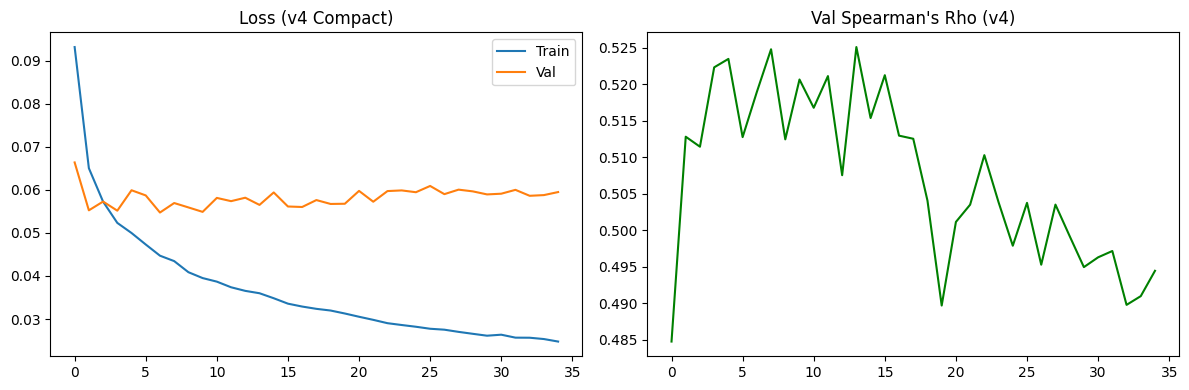

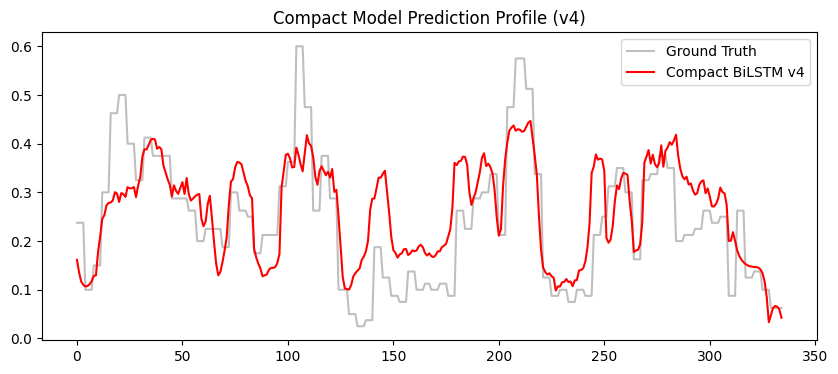

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss (v4 Compact)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_spearman'], color='green')
plt.title("Val Spearman's Rho (v4)")

plt.tight_layout()
plt.show()

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
with torch.no_grad():
    x_s, y_s = next(iter(val_loader))
    p_s = torch.clamp(model(x_s.to(DEVICE)), 0, 1).cpu().squeeze().numpy()
    y_s = y_s.squeeze().numpy()
    
    plt.figure(figsize=(10, 4))
    plt.plot(y_s, color='gray', alpha=0.5, label='Ground Truth')
    plt.plot(p_s, color='red', label='Compact BiLSTM v4')
    plt.title("Compact Model Prediction Profile (v4)")
    plt.legend()
    plt.show()